<a href="https://colab.research.google.com/github/AndreyBocharnikov/sincnet/blob/main/Experiments_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 1

## Подготовка к экспериментам

Поставим нужные библиотеки, скопируем датасет на локальную машину, залогинимся в wandb

In [ ]:
!git clone git@github.com:AndreyBocharnikov/sincnet.git

In [ ]:
!pip install wandb
!pip install -U PyYAML
!pip install torchaudio

In [ ]:
%cd sincnet

/content/sincnet


In [ ]:
!bins/timit_lowercase.sh

In [ ]:
%cd src

/content/sincnet/src


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from IPython.display import display, Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 33, 27

def draw_three_images(path1: str, path2: str, path3: str):
    img1, img2, img3 = mpimg.imread(path1), mpimg.imread(path2), mpimg.imread(path3)

    fig, ax = plt.subplots(1,3)
    ax[0].axis('off')
    ax[0].imshow(img1);
    ax[1].axis('off')
    ax[1].imshow(img2);
    ax[2].axis('off')
    ax[2].imshow(img3);

## Ээээээксперименты!

Я воспроизводил подход и результаты из статьи "Speaker recognition from raw waveform with Sincnet".  

Решаемая задача - распознавание спикера, затем, выученная на этой задаче модель, используется в задаче speaker verification.  

Основная идея подхода заключается в том, чтобы заменить стандартные свёрточные слои в первом слое модели на полосовые фильтры. Авторы мотивируют это тем, что первому слою довольно сложно выучить осмысленные фильтры, из-за того, что ему приходится работать с высокоразмерным входом и из-за затухания градиента. 
Поэтому авторы вводят полосовые фильтры, в которых нужно выучивать всего 2 параметра (верхнюю и нижнюю границы частот, которые параметризуют sinc функции, которыми и задаются полосовые фильтры), а не все элементы фильтра, как в стандартных свёртках. Хотя эти фильтры и обладают меньшей выразительной способностью по сравнению со стандартными свёртками, благодаря bias'у заложенному в них, они выучивают представления более полезные чем те, которые выучиваются случайно инициализированными стандартными свёртками.  

Авторы утверждают, что используя такие фильтры, модель быстрее сходится и демонстрирует более высокие показатели метрик.

Все эксперименты ставились на датасете TIMIT, так как авторы учили на нём одну модель 24 часа, учить модели на librispeech-100, который в 10 раз больше не представляется возможным.

### Задача Speaker recognition

#### Получающиеся метрики

Проверим утверждения авторов о том, что их модель показывает более высокие метрики качества, для этого обучим baseline, в котором в качестве первой свёртки используется стандартная 1d свёртка, а затем заменим её на предлагаемую авторами свёртку.

In [ ]:
!python main.py # baseline run

id zkoioxdj
wandb: Currently logged in as: bch (use `wandb login --relogin` to force relogin)
2021-06-10 22:36:29.355297: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.32
wandb: Syncing run lively-elevator-23
wandb: ⭐️ View project at https://wandb.ai/bch/SincNet
wandb: 🚀 View run at https://wandb.ai/bch/SincNet/runs/zkoioxdj
wandb: Run data is saved locally in /content/sincnet/wandb/run-20210610_223628-zkoioxdj
wandb: Run `wandb offline` to turn off syncing.



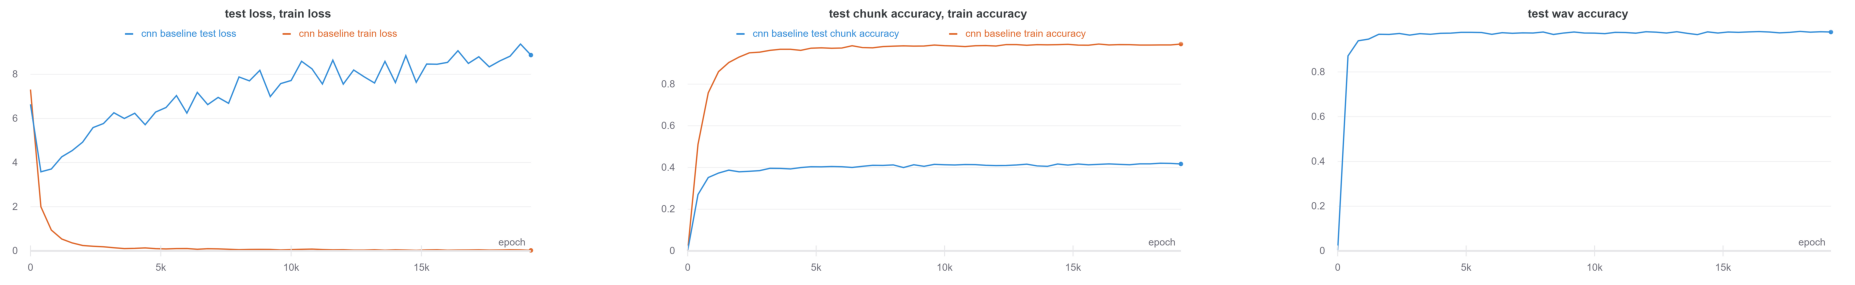

In [ ]:
draw_three_images('sincnet/report/baseline metrics/train&test loss.png', 'sincnet/report/baseline metrics/train&test frame accuracy.png',
                  'sincnet/report/baseline metrics/test speaker accuracy.png')

Как видно из графиков, модель сильно переобучается - loss на тесте растёт, а точность на тесте сильно меньше чем на трейне, но у авторов происходит тоже самое (это видно из секции "How to run a TIMIT experiment" -> "3. Results." в их readme, loss на тесте растёт, точность на тесте сильно меньше чем на трейне), но авторы учат именно столько эпох, потому что метрика, точность классификации дорожки, продолжает расти.  
Получающаяся у меня точность классификации спикеров - примерно 0.98, это не сильно отличается от заявленных авторами 0.9835, учитывая что я учил 345600 итераций градиентного спуска (12 часов), а не 1200000 итераций (24 часа), как это делали авторы.

Обучим `SincNet` такое же число итераций градиентного спуска и сравним результаты

In [ ]:
!python main.py # sinc run

id 33easts1
wandb: Currently logged in as: bch (use `wandb login --relogin` to force relogin)
2021-06-10 11:21:52.150429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.31
wandb: Syncing run good-shape-19
wandb: ⭐️ View project at https://wandb.ai/bch/SincNet
wandb: 🚀 View run at https://wandb.ai/bch/SincNet/runs/33easts1
wandb: Run data is saved locally in /content/sincnet/wandb/run-20210610_112146-33easts1
wandb: Run `wandb offline` to turn off syncing.



В этом запуске получаются 3 аналогичных графика, но получаются лучшие метрики на тестовом множестве - точность на фреймах выше на 8%, точность по всем дорожкам получается  примерно 0.9848 - 0.9928, то есть очень близко, к 0.9915, заявленным авторами в таблице 1.

Промежуточный вывод о получающихся метриках - подход авторов работает лучше, этот результат воспроизводится.

#### Скорость сходимости

Теперь проверим утверждения авторов о том, что предлагаемая ими модель сходится быстрее. Для этого запустим 2 аналогичных обучения модели, но на меньшем кол-ве итераций градиентного спуска, и для наглядности, будем выводить метрики чаще.

In [ ]:
!python main.py # baseline short run

id 27yg5by9
wandb: Currently logged in as: bch (use `wandb login --relogin` to force relogin)
2021-06-11 17:12:11.010184: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.32
wandb: Syncing run fragrant-oath-25
wandb: ⭐️ View project at https://wandb.ai/bch/SincNet
wandb: 🚀 View run at https://wandb.ai/bch/SincNet/runs/27yg5by9
wandb: Run data is saved locally in /content/sincnet/wandb/run-20210611_171209-27yg5by9
wandb: Run `wandb offline` to turn off syncing.



In [ ]:
!python main.py # sinc short run

id 295ny68u
wandb: Currently logged in as: bch (use `wandb login --relogin` to force relogin)
2021-06-11 18:21:34.153028: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.32
wandb: Syncing run spring-dragon-26
wandb: ⭐️ View project at https://wandb.ai/bch/SincNet
wandb: 🚀 View run at https://wandb.ai/bch/SincNet/runs/295ny68u
wandb: Run data is saved locally in /content/sincnet/wandb/run-20210611_182132-295ny68u
wandb: Run `wandb offline` to turn off syncing.



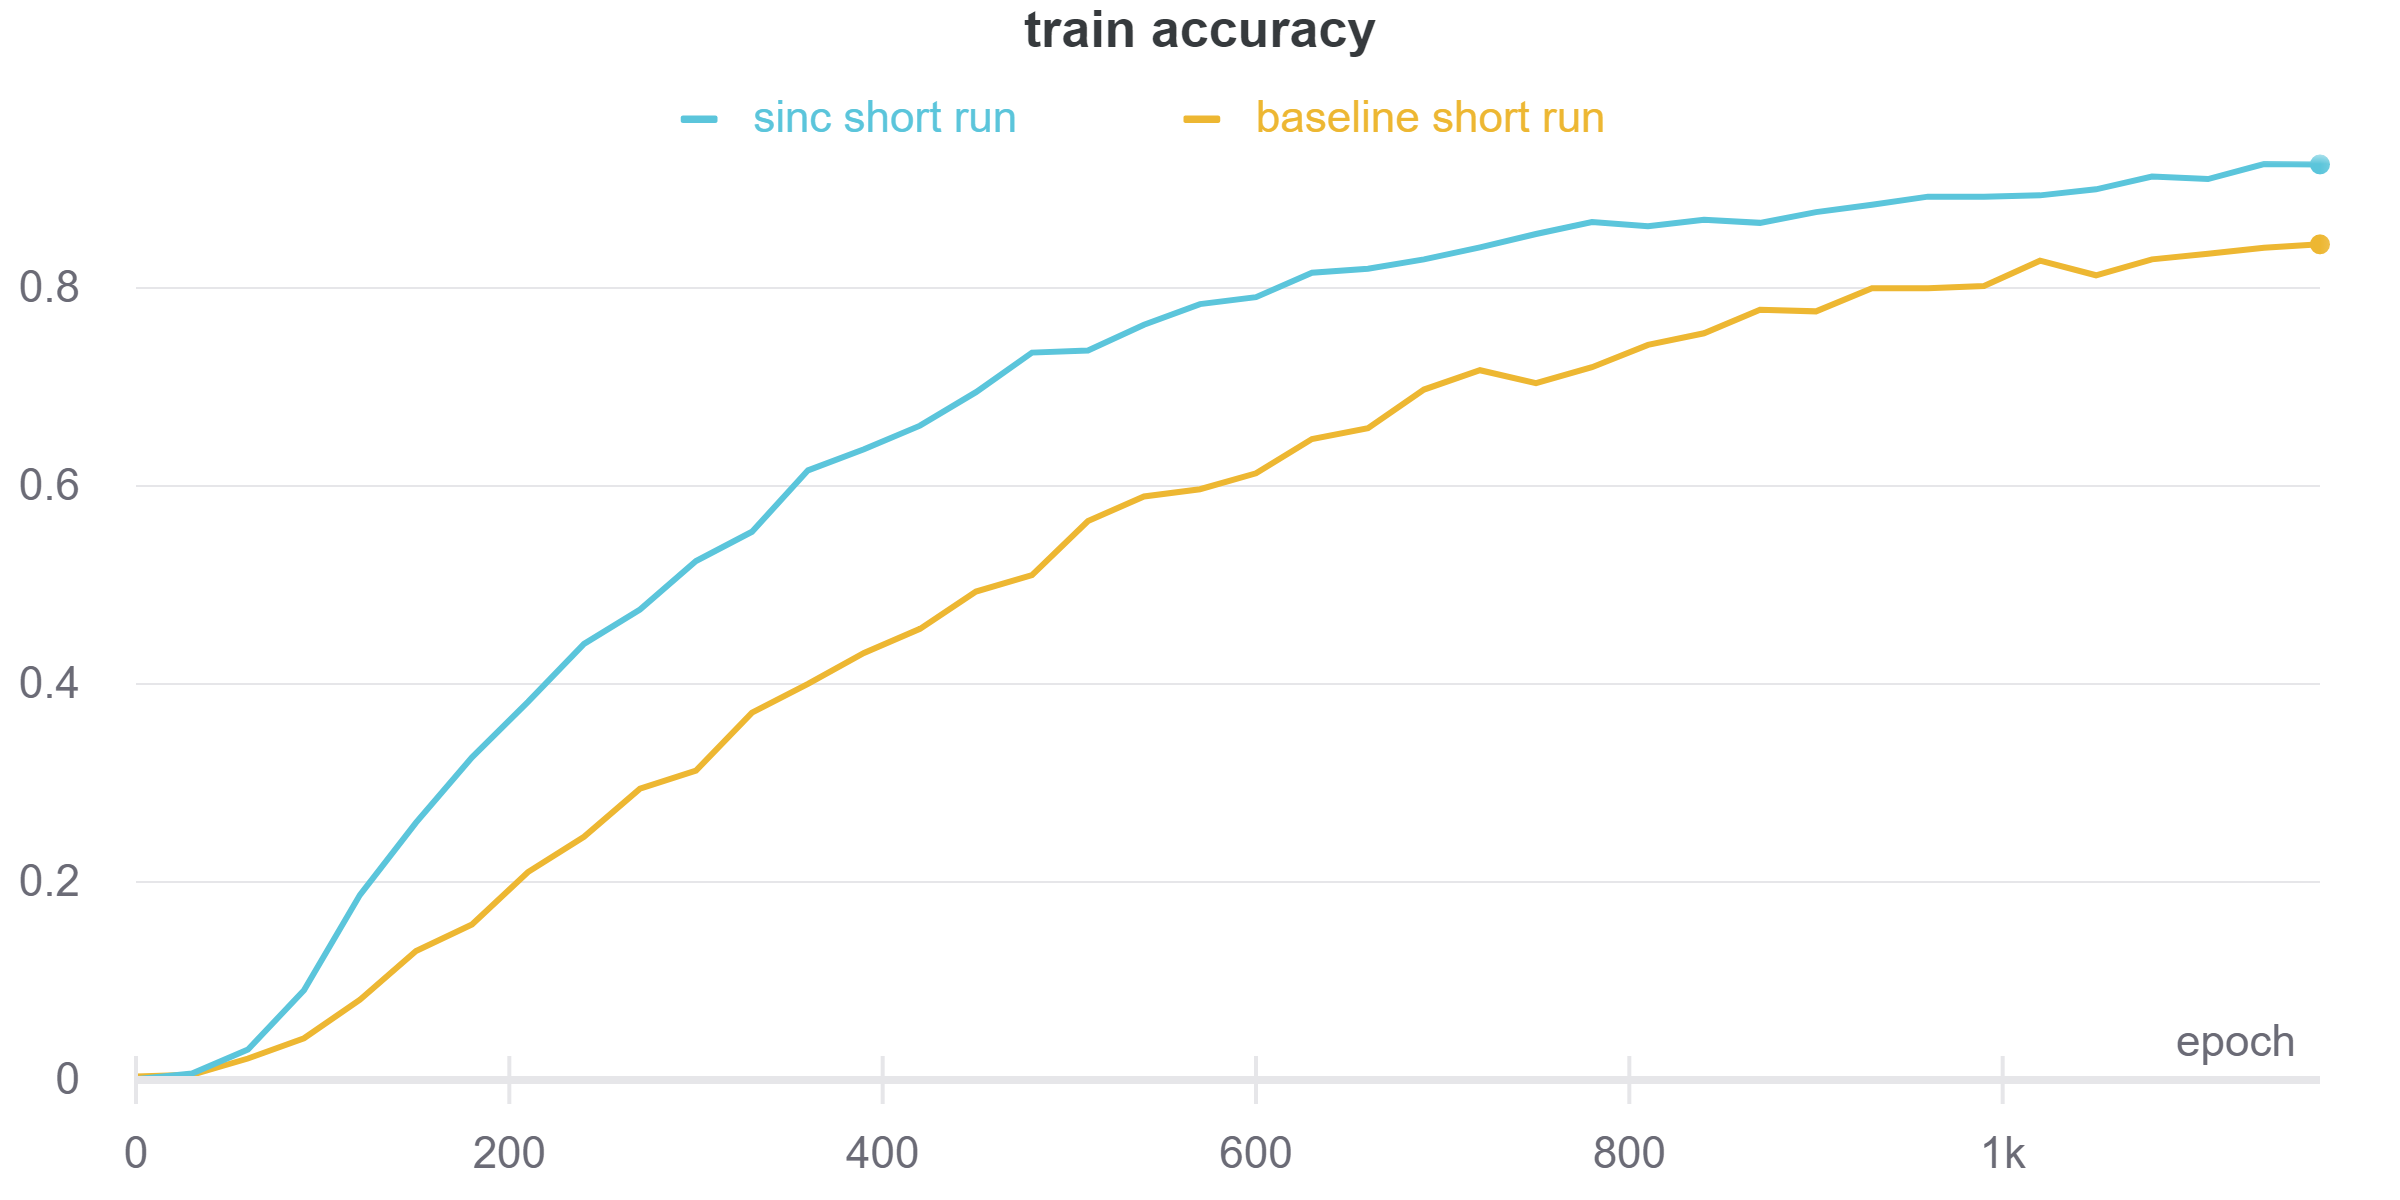

In [ ]:
Image(filename='sincnet/report/converges.png', width=600, height=300)

Как мы видим, получается график, очень похожий на график номер 4 из статьи (frame error rate заменён на frame accuracy).  
То есть результаты авторов о сходимости также воспроизводятся.

### Задача speaker verification

Теперь займёмся задачей speaker verification, посмотрим воспроизводятся ли там результаты авторов.

In [ ]:
%env PYTHONPATH=/env/python:/content/sincnet/src

env: PYTHONPATH=/env/python:/content/sincnet


Для этого посчитаем `d-vector`'а на тестовом мн-ве timit'а (этих спикеров сетка не видела во время обучения), а трейн часть timit'а будем обрабатывать так: на трейн сплите посчитаем для каждого спикера средний `d-vector`, а тест часть будем ипользовать как валидацию. Итоговый pipeline - пробегаемся по тестовой части трейн сплита timit'а, считаем `d-vector` текущей дорожки, берём 10 рандомных импостеров из тестового мн-ва, затем в зависимости от способа (dnn или косинусное расстояние) либо 11 раз делаем предсказания и берём правильный класс в каждом предсказнии(в случае dnn), либо добавляем к 10 импостерам `d-vector` из трейн части трейн сплита правильного класса и считаем расстояния от текущего вектора до этих 11. Затем получив по 11 значений для каждой дорожки из тестовой части трейн сплита считаем EER.

Считаем `d-vector`'а baseline модели для трейн части трейн сплита

In [ ]:
pretrained_conv = "model/cnn.pt"
compute_split = "train.scp"
!python speaker_verification/compute_d_vectors.py cnn $pretrained_conv $compute_split --save_to d_vectors_conv.npy

Считаем `d-vector`'а baseline модели для тестового сплита

In [ ]:
pretrained_conv = "model/cnn.pt"
compute_split = "sv.scp"
!python speaker_verification/compute_d_vectors.py cnn $pretrained_conv $compute_split --save_to d_vectors_conv_unseen.npy

Считаем err с помощью косинусного расстояния

In [ ]:
dv_speakers = "/content/sincnet/src/d_vectors_conv.npy"
dv_imposters = "/content/sincnet/src/d_vectors_conv_unseen.npy"
!python speaker_verification/speaker_verification.py cnn $pretrained_conv $dv_speakers $dv_imposters cos

0.03163780663768459


Считаем err с помощью dnn

In [ ]:
!python speaker_verification/speaker_verification.py cnn $pretrained_conv $dv_speakers $dv_imposters softmax

0.33549783549771584


Проделаем аналогичные 4 шага для `SincNet` модели

In [ ]:
pretrained_sinc = "model/sinc.pt"
compute_split = "train.scp"
!python speaker_verification/compute_d_vectors.py sinc $pretrained_sinc $compute_split --save_to d_vectors_sinc.npy

In [ ]:
pretrained_sinc = "model/sinc.pt"
compute_split = "sv.scp"
!python speaker_verification/compute_d_vectors.py sinc $pretrained_sinc $compute_split --save_to d_vectors_sinc_unseen.npy

In [ ]:
dv_speakers = "/content/sincnet/src/d_vectors_sinc.npy"
dv_imposters = "/content/sincnet/src/d_vectors_sinc.npy"
!python speaker_verification/speaker_verification.py sinc $pretrained_sinc $dv_speakers $dv_imposters cos

0.01735209235197047


In [ ]:
!python speaker_verification/speaker_verification.py sinc $pretrained_sinc $dv_speakers $dv_imposters softmax

0.27474747474736105


Проанализируем результаты и сравним их с результатами авторов из таблички 2:  

|              | dnn   | cosine dist |
|--------------|-------|-------------|
| cnn baseline | 0.335 | 0.032       |
| SincNet      | 0.275 | 0.017       |

Результаты dnn получаются того же порядка, как и у авторов, но немного лучше, я думаю это связанно с тем, что датасет timit легче датасета librispeech, так как в нём 462 спикера, а не 2484. Резульаты же в случае косинусного расстояния получаются на несколько порядков лучше, я думаю это свзяанно с тем, что авторы сравнивают результаты, полученные на разных задачах - в случае dnn верифицируются только те спикер, на которых модель училась, а в случае косинусного расстояния только те, которых она не видела. И очевидно, что модель будет давать результаты лучше, работая с теми же спикерами на которых она училась, поэтому полученные мной результаты на несколько порядков лучше. Но на мой взгляд не правильно сравнивать результаты разных подхов на разных задачах, поэтому я оставлю свои результаты. Тем более, в результатах авторов какая-то ошибка, невозможно получить err болше 0.5, если во всех предсказаниях поменять расстояние на противоположный знак, результаты станут лучше (1 - результат который был), а лучший результат авторов в случае косинусного расстояния - 0.51.  

Но тот факт, что в обоих подходах, предлагаемая авторами `SincNet` даёт лучший результат чем baseline воспроизводится.

## Заключение

Подытожим поставленные эксперименты, авторы статьи акцентируют внимание на трёх моментах, предлагаемый ими подход:
*   показывает лучшие метрики качества чем baseline
*   быстрее сходится
*   показывает лучшие результаты на downstream задаче speaker verification

По поставленным экспериментам можно сказать, что все утверждения выше воспроизводятся!

"Какие есть перспективы для развития?" - Некоторые задачи обработки звука, такие как speech enhancement и speaker diarization работают с wav входом, а не с mel спектрограммами, и в архитектурах, которые решают такие задачи, можно попробовать подход авторов и заменить обычные свёртки в первом слое на свёртки, предлагаемые авторами. Это может привести к лучшей сходимости и более высоким показателям метрик.

# Задача 2

Очень сложно остановиться на одной какой-то статье как этого просят в задание, поэтому я остановлюсь на нескольких идеях которые одновременно кажутся интересными мне и подходят под задачу, решаемую на стажировке:  
*   Трансформеры в аудио: за последний год вышло очень много статей на тему ускорения работы трансформеров, а за последние полгода на тему трансформеров в CV, в то же время применение трансформеров в аудио не является таким популярным, хотя учитывая их результаты в nlp, и в cv такой недостаток внимания является неоправданным. Статье о применение трансформеров в аудио, которые я читал: [FastSpeech](https://arxiv.org/abs/1905.09263), [Transformers are RNNs](https://arxiv.org/abs/2006.16236), [Streaming Transformer ASR](https://arxiv.org/abs/2006.14941) и [Reformer-TTS](https://www.isca-speech.org/archive/Interspeech_2020/pdfs/2189.pdf), в которых решаются задачи ASR и TTS.
*   Также в последнее время мне нравится изучать статьи о style transfer'е, которые применяют один и тот же подход в разных доменах, то есть и в картинках и в звуке, такие как [Style GAN](https://arxiv.org/abs/1812.04948) и [Adain-VC](https://arxiv.org/abs/1904.05742), [CycleGAN](https://arxiv.org/abs/1703.10593) и [CycleGAN-VC](http://www.kecl.ntt.co.jp/people/kaneko.takuhiro/projects/cyclegan-vc/), [StarGAN](https://arxiv.org/abs/1711.09020) и [StarGAN-VC](https://arxiv.org/abs/1806.02169?source=post_page---------------------------).  

Буду рад обсудить любую из этих статей.



